# Load Packages

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import randint, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model Tuning
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

import xgboost as xgb
import lightgbm as lgb


from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import set_config
# set_config(display='diagram')

import os
import psutil


import warnings
# warnings.filterwarnings('ignore')

# Ignore the warning
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# Load Data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png" width=600>

> Data Readme
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Load RAW data

In [3]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'Id'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature-Target split

In [4]:
# define the target column in the train dataset
target = 'SalePrice'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (1460, 79), shape of y is (1460,)


## Missing Values Inspection

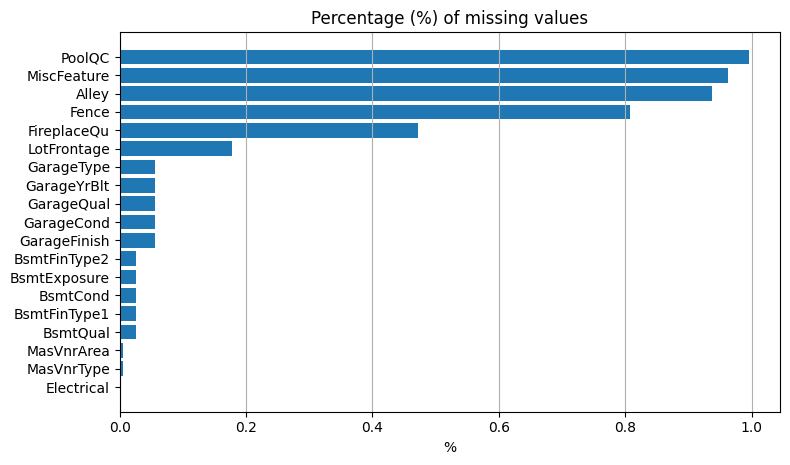

In [4]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

# visualize
plt.figure(figsize=(8, feature_null.shape[0]/4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

# features have large % of missing values should be considerred DROP

## Feature Selection

In [19]:
X = data.drop(columns = target).copy()
features_all = X.columns.sort_values().to_list()

features_to_drop = [
    #to many missing values
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
    #highly unbalanced numerical feature
    '3SsnPorch', 'BsmtFinSF2','BsmtHalfBath', 'EnclosedPorch','KitchenAbvGr', 'LowQualFinSF', 'MiscVal', 'PoolArea', 'ScreenPorch', 
    #highly unbalanced categorical feature
    'Condition2', 'Functional', 'GarageCond',  'GarageQual', 'Heating','LandSlope','RoofMatl', 'Street', 'Utilities',
    #categorical feature which may create many OneHotEncoder columns
    'Exterior1st', 'Exterior2nd', 'Neighborhood', 'SaleType', 'Condition1',
    'BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Electrical', 
    #dropped all non oridinal features???
#     'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle', 'LandContour', 'LotConfig', 
#     'LotShape', 'MSZoning', 'MasVnrType', 'PavedDrive', 'RoofStyle', 'SaleCondition'
]
# columns_to_drop = []
X = X.drop(columns=features_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.sort_values().to_list()

# Numerical features following uniform distrution
feature_numerical_norm = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                          'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
# feature_numerical_norm = []

feature_numerical_uniform = [key for key in feature_numerical 
                              if key not in feature_numerical_norm]

feature_categorical = X.select_dtypes(include='object').columns.sort_values().to_list()

feature_categorical_Ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'FireplaceQu', 'HeatingQC', 'KitchenQual'
]
feature_categorical_Ordinal.sort()
# feature_categorical_Ordinal=[]

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print('--------OVERVIEW----------')

print(f'All features (\033[95m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(columns_to_drop)}\
\033[0m): \033[94m{columns_to_drop}\033[0m')

print('--------CATEGORICAL----------')

print(f'Categorical cat features (\033[95m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\033[95m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[95m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')

print('---------NUMERICAL---------')

print(f'Numerical features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')

--------OVERVIEW----------
All features (79): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleTyp

NameError: name 'columns_to_drop' is not defined

# Data Exploration

## Distribution of each numerical feature

In [6]:
print(f'Numerical features (\033[94m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m') 

Numerical features (27): ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'LotArea', 'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


Numerical features (19): ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFullBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


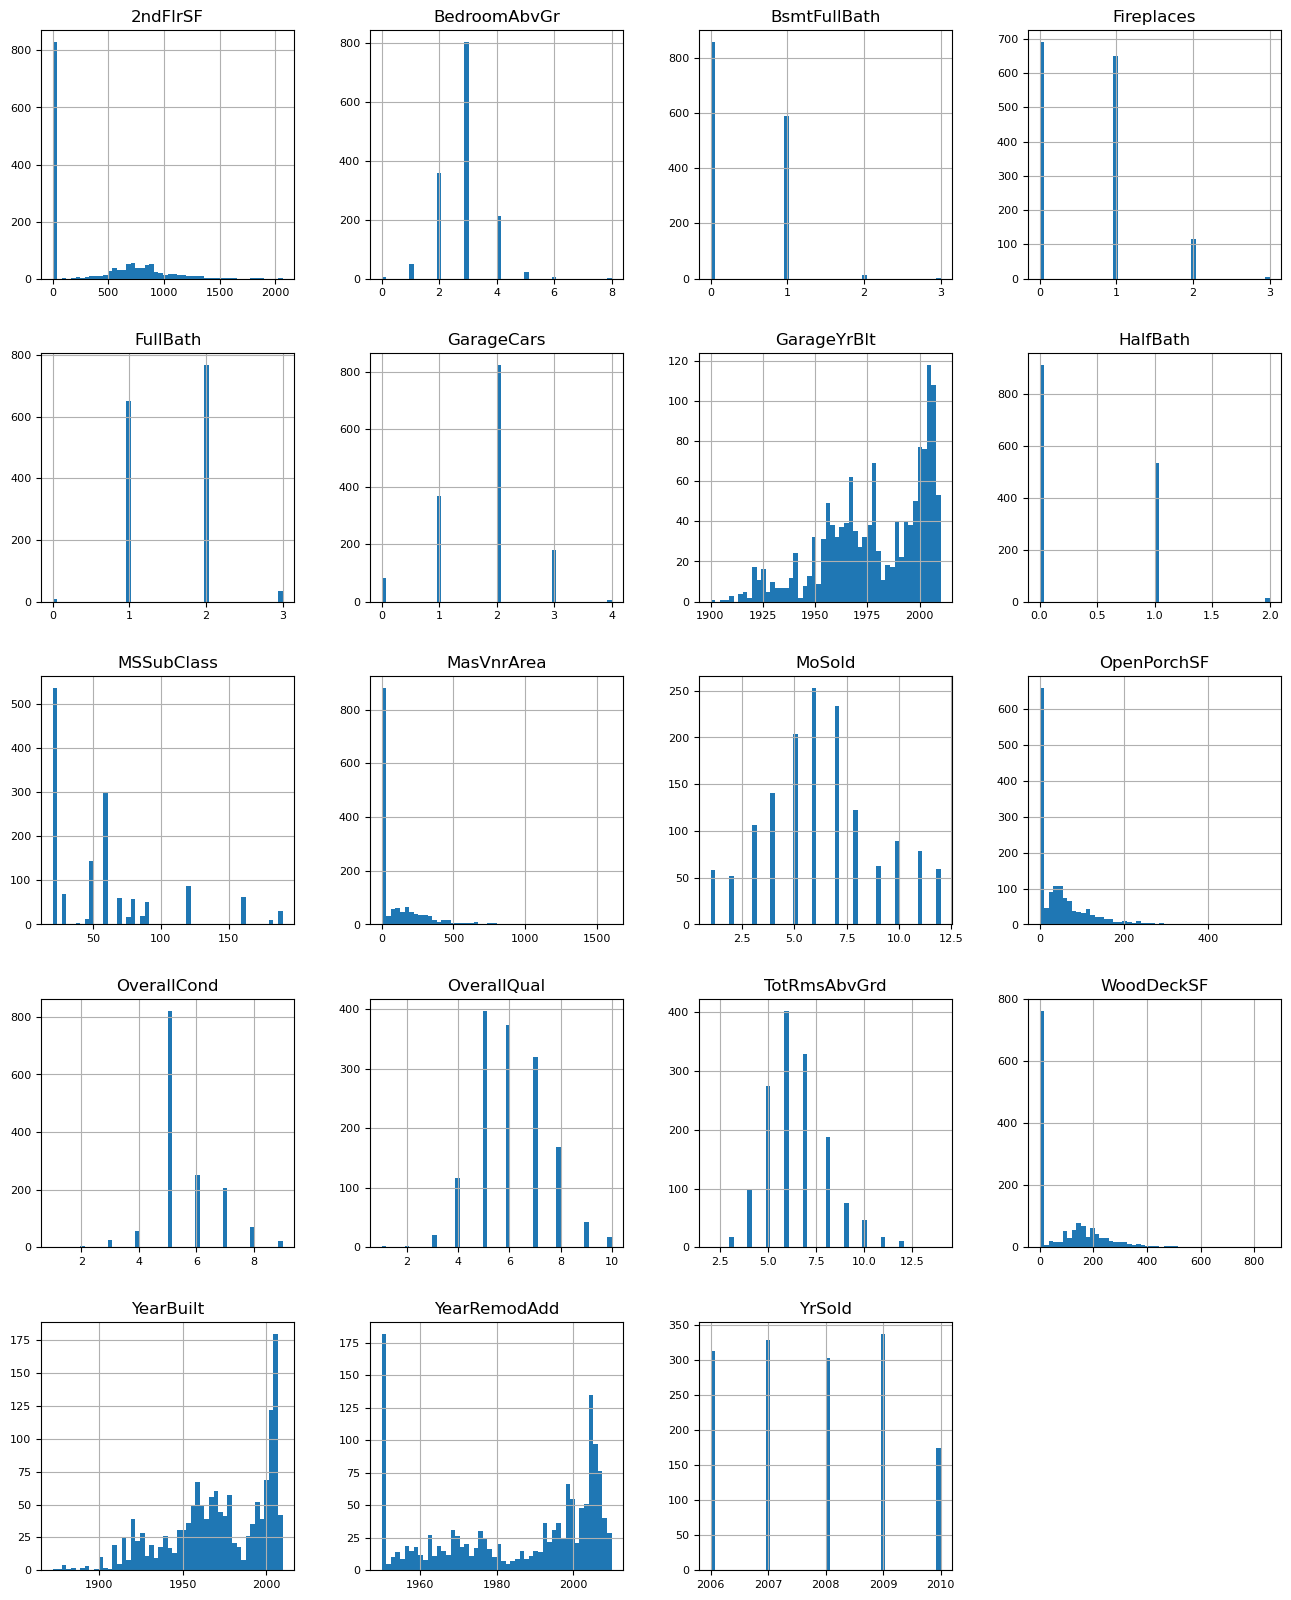

In [7]:
print(f'Numerical features (\033[94m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')
X[feature_numerical_uniform].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

Numerical features (8): ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']


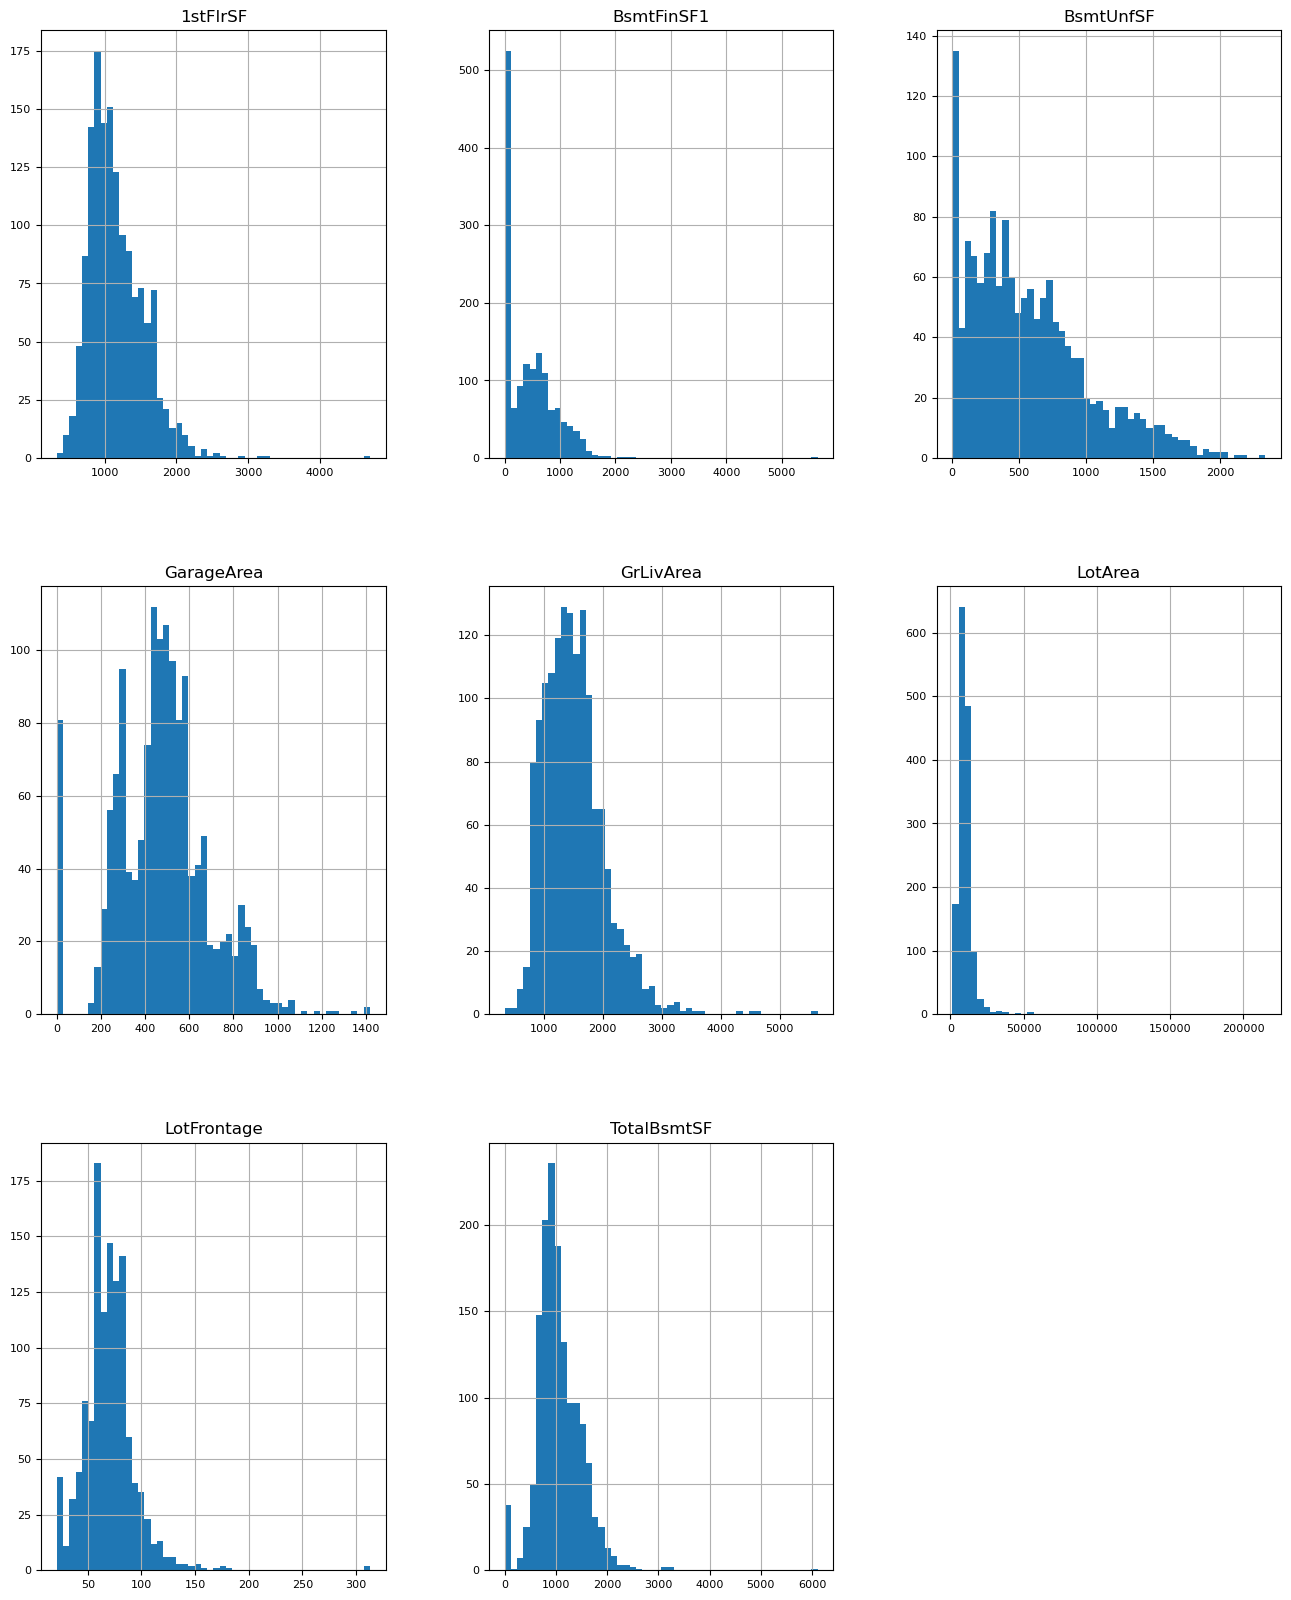

In [14]:
print(f'Numerical features (\033[94m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

X[feature_numerical_norm].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

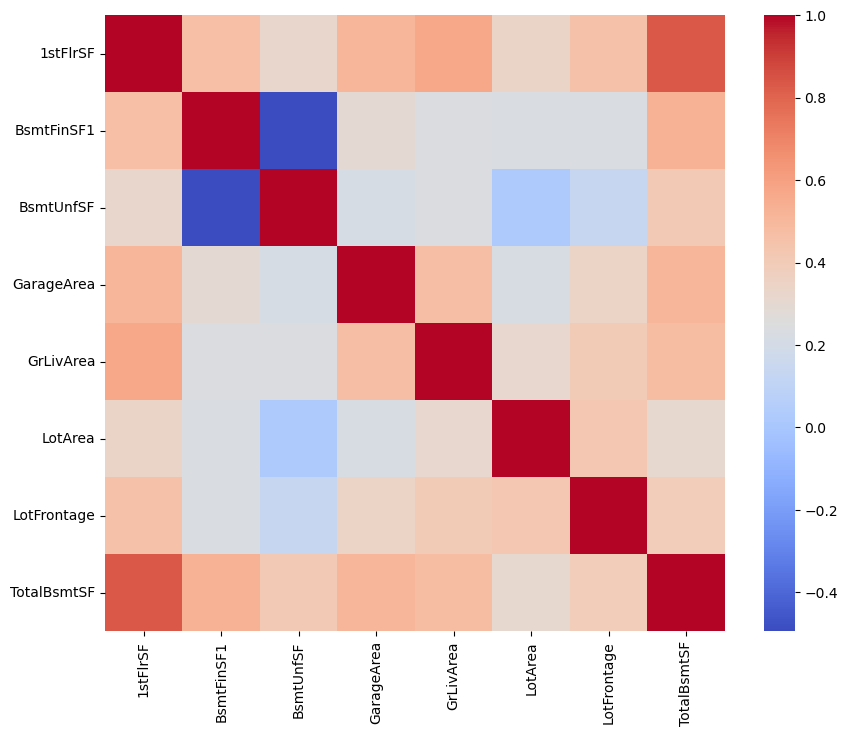

In [12]:
X_num = X[feature_numerical_norm].dropna()

# figsize
plt.figure(figsize=(10,8))
sns.heatmap(X_num.corr(), cmap='coolwarm')

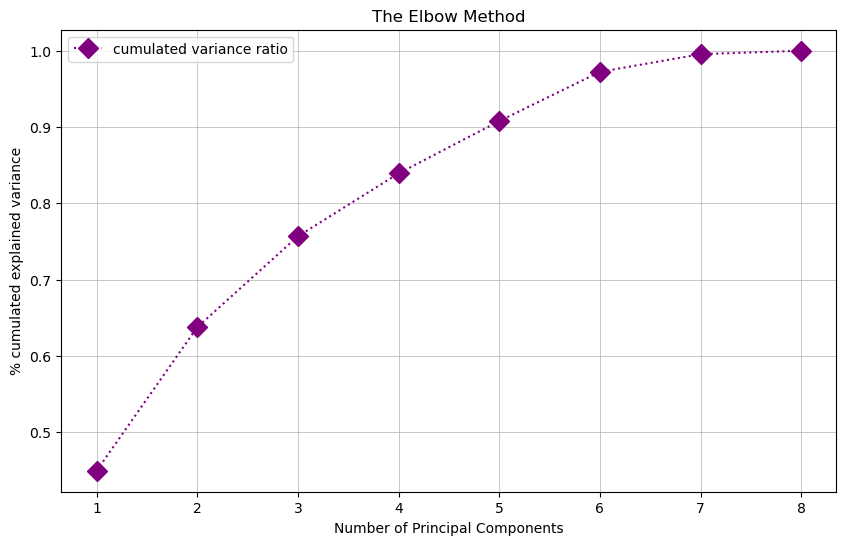

In [13]:
pca = PCA()
X_scaled = StandardScaler().fit_transform(X_num)
X_pca = pca.fit_transform(X_scaled)

with plt.style.context('seaborn-deep'):
    
    # figsize
    plt.figure(figsize=(10,6))
    
    # getting axes
    ax = plt.gca()
    
    # plotting
    evr_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,evr_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,evr_cumulated,label="cumulated variance ratio",
            color="purple",linestyle=":",marker="D",markersize=10)
    
    
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
#     ax.scatter(15,evr_cumulated[15-1],c='blue',s=400)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

## Distribution of each catigorical feature

Categorical cat features (7): ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'HeatingQC', 'KitchenQual']


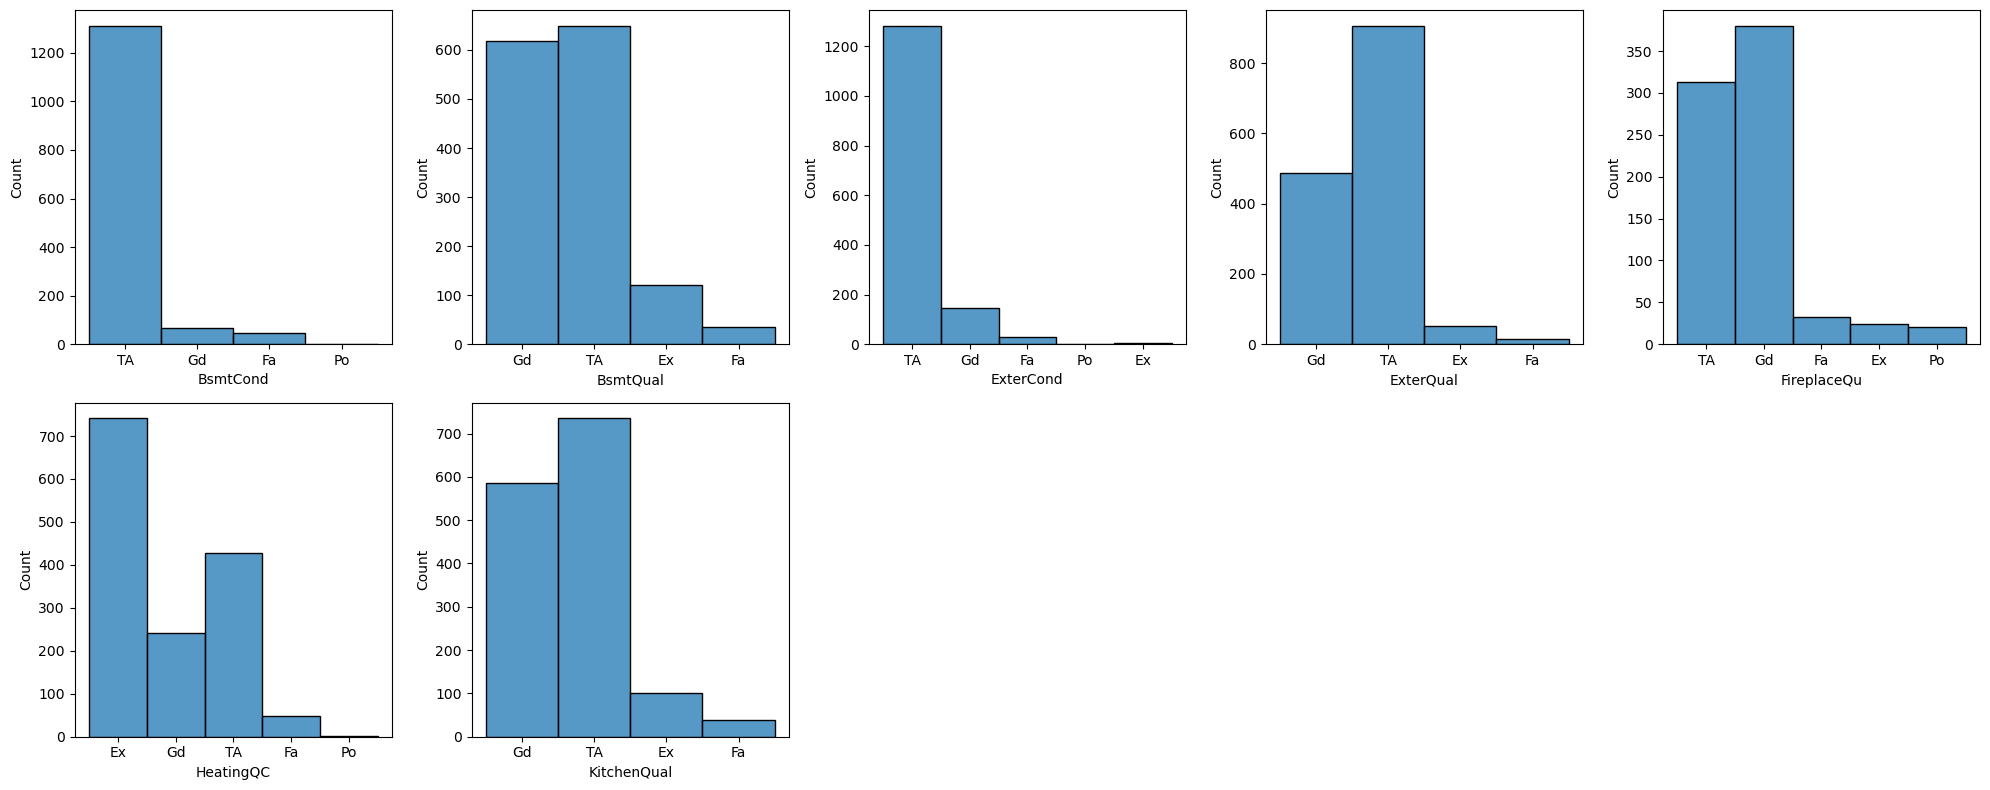

In [15]:
plot_list=feature_categorical

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# Assuming 'X' is your DataFrame
num_cols = 5  # Number of columns in the grid
num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

# Plot each categorical feature
for i, feature in enumerate(plot_list):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    sns.histplot(data=X, x=feature, kde=False, ax=ax)

# Hide unused subplots
if len(plot_list) < num_rows * num_cols:
    for j in range(len(plot_list), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

## Distribution of each catigorical Ordinal feature

Categorical cat features (7): ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'HeatingQC', 'KitchenQual']


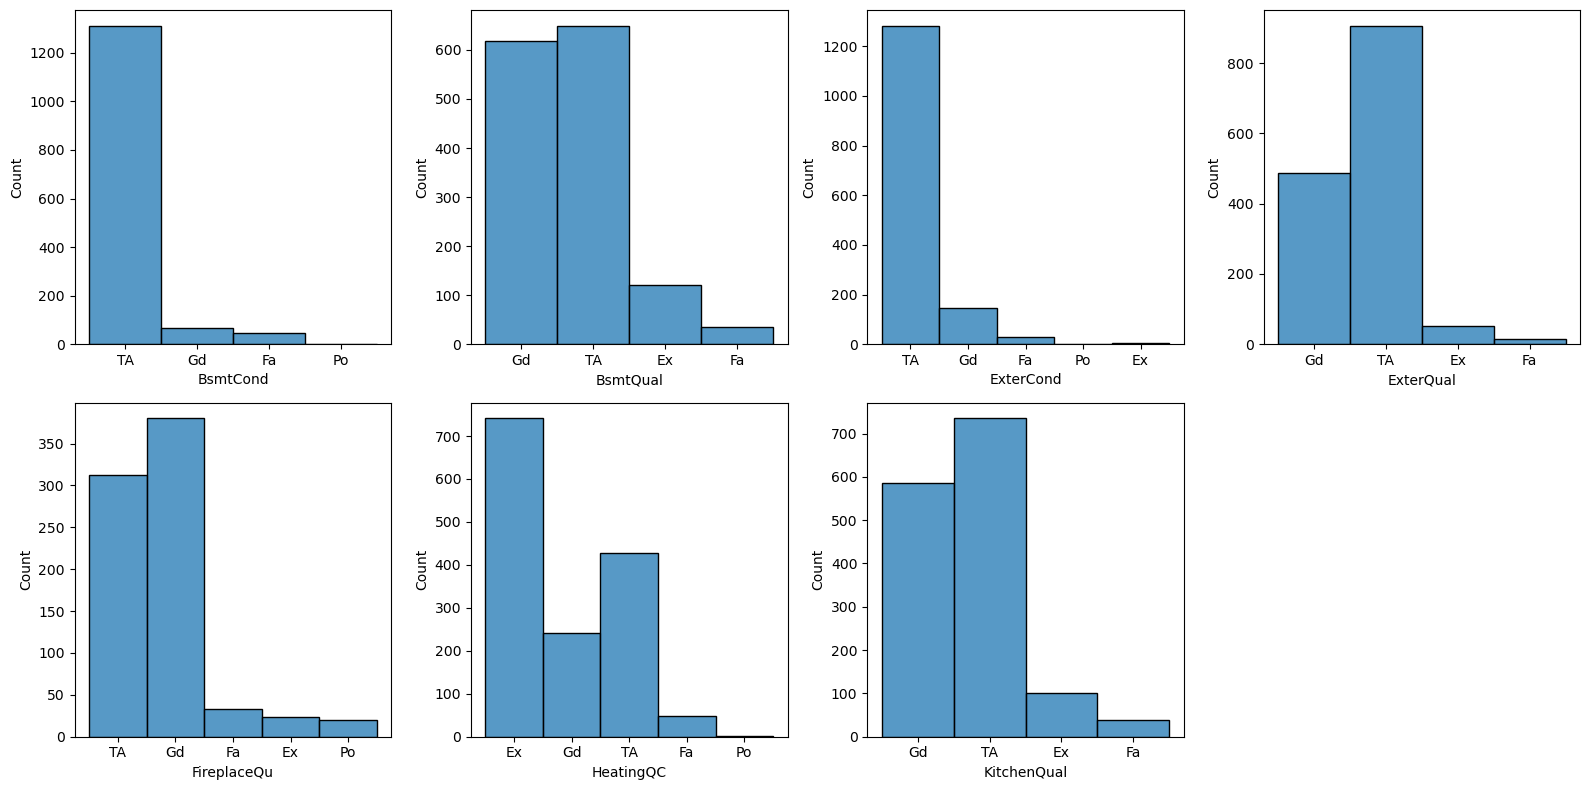

In [16]:
plot_list = feature_categorical_Ordinal

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
feat_ordinal_dict = {
    # considers "missing" as the worse category
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
#     "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
#     "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
#     "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex']
#     "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
#     "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
#     "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
#     "PavedDrive": ['missing', 'N', 'P', 'Y'],
#     "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}


ordinal_features = list(feat_ordinal_dict.keys())
ordinal_values = list(feat_ordinal_dict.values())
print('complete')

complete


## Distribution of each catigorical OneHot feature

Categorical cat features (12): ['HouseStyle' 'Foundation' 'GarageType' 'RoofStyle' 'SaleCondition'
 'LotConfig' 'MSZoning' 'LandContour' 'LotShape' 'MasVnrType'
 'GarageFinish' 'PavedDrive']


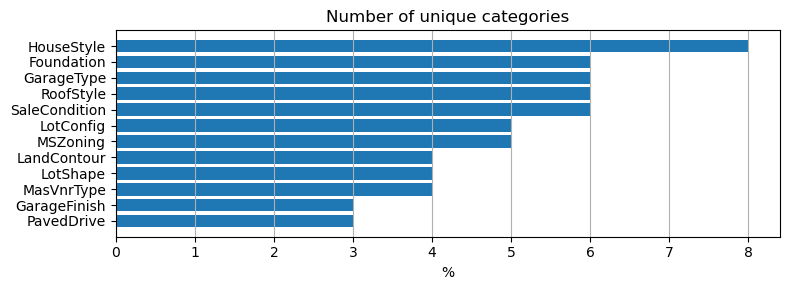

In [20]:
# list the number of categories of each OneHot feature
feature_cat_value_count= X[feature_categorical_OneHot].nunique().sort_values(ascending=False)
feature_cat_value_count=feature_cat_value_count[feature_cat_value_count>0]
plot_list = feature_cat_value_count[feature_cat_value_count>0].keys().values

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# visualize
plt.figure(figsize=(8, len(plot_list)/4))
feature_ranks = range(len(plot_list))
bar = plt.barh(feature_cat_value_count.index, 
               feature_cat_value_count.values, 
               label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Number of unique categories")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Categorical cat features (12): ['Foundation', 'GarageFinish', 'GarageType', 'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'PavedDrive', 'RoofStyle', 'SaleCondition']


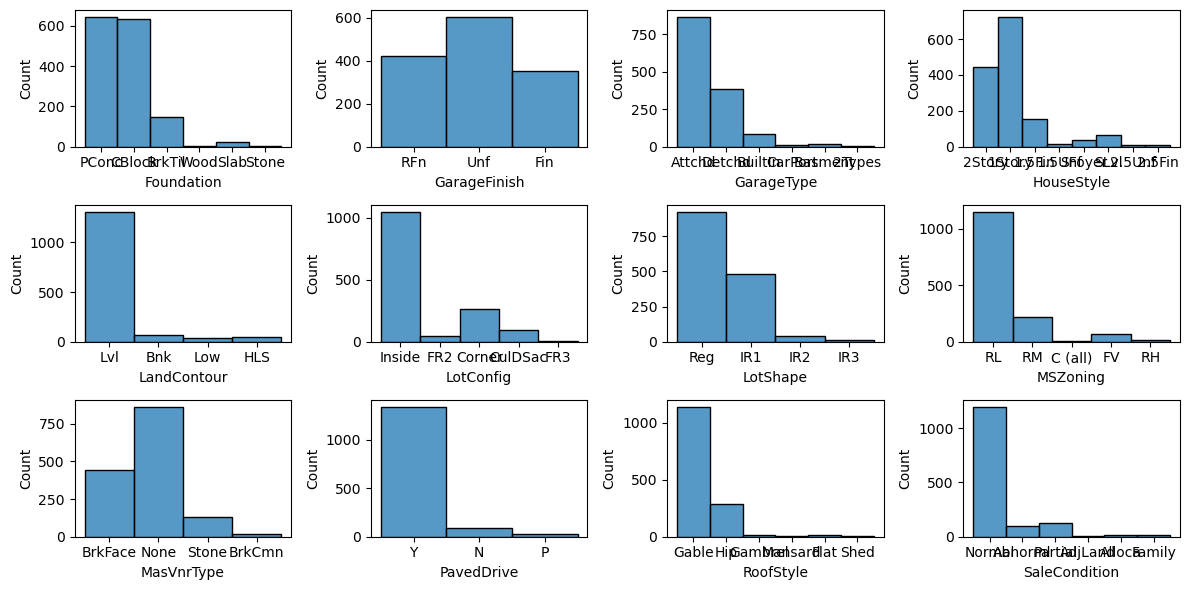

In [21]:
plot_list=feature_categorical_OneHot

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [24]:
#transformer for numerical data
preproc_num_norm = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler()
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_num_uniform = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler(),
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Missing'),
    OrdinalEncoder(
        categories=ordinal_values,
        dtype=np.int64,
        handle_unknown="use_encoded_value", unknown_value=-1
    ),
    MinMaxScaler()
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore')
)

preproc_pipeline = ColumnTransformer([
    ('ordinal processor', preproc_cat_ordinal, feature_categorical_Ordinal),
    ('numerical processor norm', preproc_num_norm, feature_numerical_norm),
    ('numerical processor uniform', preproc_num_uniform, feature_numerical_uniform),
    ('categorical processor', preproc_cat_onehot, feature_categorical_OneHot),
#     remainder='passthrough'
])

X_preprocessed = preproc_pipeline.fit_transform(X)
y_log=np.log(y)
X_preprocessed.shape, y.shape

((1460, 97), (1460,))

# Models

## Custom Loss Function

In [ ]:
def my_rmsle_neg(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle_neg = make_scorer(my_rmsle_neg)

def my_rmsle(y_true, y_pred):
    return (np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

In [ ]:
def my_rmsle(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

## Cross Validation

In [ ]:
# this code is to use cross validation to screen 
# all available models with default hyperparameters
# please comment out the models which are not relevant

models = {
    'KNN Regressor': KNeighborsRegressor(),
#     'KNN Classifier': KNeighborsClassifier(),
#     'SVC': SVC(),
#     'SVC_poly': SVC(kernel='poly'),
#     'SVC_linear': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeRegressor(),
#     'LinearRegression': LinearRegression(),
#     'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': xgb.XGBRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'lightGBM Regressor': lgb.LGBMRegressor(),
#     'lightGBM Classifier': lgb.LGBMClassifier()
}

print('Baseline Score(s) of each model are ....')
for name in models:
#     cv_result = cross_val_score(models[name], 
#                                 X_fit, 
#                                 y, 
#                                 cv=5, 
#                                 scoring=rmsle_neg, 
#                                 n_jobs=-1)
    cv_result = cross_val_score(models[name], 
                                X_preprocessed, 
                                y_log, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1)
    print(f'Average score: \033[94m{-(-cv_result.mean())**.5}\033[0m by \033[94m{name}\033[0m.')

## Model Tuning

### Gradient Boost

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = GradientBoostingRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

gd_study = optuna.create_study(direction='maximize')
gd_study.optimize(objective, n_jobs=-1, n_trials=1000)

best_gd_model = GradientBoostingRegressor(**gd_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(gd_study.best_trial)

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 07:33:19,525] Trial 996 finished with value: -0.14128902086321699 and 
# parameters: {'n_estimators': 384, 'learning_rate': 0.07886590996608028, 'max_depth': 8, 
# 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.8477516222094403}. 
# Best is trial 749 with value: -0.13011753420930586.
# 
# FrozenTrial(number=749, state=TrialState.COMPLETE, 
# values=[-0.13011753420930586], datetime_start=datetime.datetime(2023, 5, 29, 7, 28, 3, 12290), 
# datetime_complete=datetime.datetime(2023, 5, 29, 7, 28, 11, 888495), 
# params={
# 'n_estimators': 380, 'learning_rate': 0.05968108162828581, 'max_depth': 3, 
# 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6630066373055117}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 
# 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, 
# trial_id=749, value=None)

### KNN

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 3)
    }
    model = KNeighborsRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(objective, n_jobs=-1, n_trials=100)

best_knn_model = KNeighborsRegressor(**knn_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(knn_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:48:00,671] Trial 49 finished with value: -0.16731462558226803 and 
# parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. 
# Best is trial 33 with value: -0.1618311568202797.

# FrozenTrial(number=33, state=TrialState.COMPLETE, values=[-0.1618311568202797], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 47, 59, 746892), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 48, 0, 84948), 
# params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, 
# intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, 
# log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 
# 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=33, value=None)

In [ ]:
# Bagged KNN
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}
best_knn_model = KNeighborsRegressor(**params)
bagged_knn = BaggingRegressor(best_knn_model, n_estimators=400)
score = np.mean(cross_val_score(bagged_knn, X_fit, y, scoring=rmsle_neg))
print(score)

### XGBoost

In [ ]:
%%time
# Model tuning using uptuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = xgb.XGBRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_jobs=-1, n_trials=50)

best_xgb_model = xgb.XGBRegressor(**xgb_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(xgb_study.best_trial)

#### Optimization History

In [36]:
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# FrozenTrial(number=216, state=TrialState.COMPLETE, values=[-0.12299496821164585], 
# datetime_start=datetime.datetime(2023, 5, 31, 8, 53, 29, 649233), 
# datetime_complete=datetime.datetime(2023, 5, 31, 8, 54, 26, 185219), 
# params={'learning_rate': 0.03267376672095758, 'max_depth': 3, 'n_estimators': 900, 
# 'subsample': 0.6606395088142445, 'colsample_bytree': 0.5015213963591287, 
# 'reg_alpha': 0.02360139542087991, 'reg_lambda': 0.3633686706222494}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=216, value=None)
          
# FrozenTrial(number=254, state=TrialState.COMPLETE, values=[-0.12656291447156245], 
# datetime_start=datetime.datetime(2023, 5, 29, 11, 15, 39, 930104), 
# datetime_complete=datetime.datetime(2023, 5, 29, 11, 17, 0, 694431), 
# params={'learning_rate': 0.027504590029994773, 'max_depth': 4, 'n_estimators': 1000, 
# 'subsample': 0.5663216990626124, 'colsample_bytree': 0.5169119673232286, 
# 'reg_alpha': 0.293253549164087, 'reg_lambda': 0.17096558062613412}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=254, value=None)

[I 2023-05-31 09:13:22,794] A new study created in memory with name: no-name-847f11e7-b37f-49cc-a34d-ae1513978ed9
[I 2023-05-31 09:13:28,795] Trial 8 finished with value: -0.5902271934267854 and parameters: {'learning_rate': 0.02991511205491997, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7394248434871152, 'colsample_bytree': 0.9396731476460165, 'reg_alpha': 0.6007689550903853, 'reg_lambda': 0.8706981438472546}. Best is trial 8 with value: -0.5902271934267854.
[I 2023-05-31 09:13:34,514] Trial 5 finished with value: -0.13405729861977772 and parameters: {'learning_rate': 0.0825428269787516, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.610405985676111, 'colsample_bytree': 0.6866704478416281, 'reg_alpha': 0.9009194600395011, 'reg_lambda': 0.7961012498020973}. Best is trial 5 with value: -0.13405729861977772.
[I 2023-05-31 09:13:36,130] Trial 2 finished with value: -0.12775398593369838 and parameters: {'learning_rate': 0.06382019656271443, 'max_depth': 3, 'n_estimators': 200

[I 2023-05-31 09:17:13,178] Trial 28 finished with value: -0.20988864885681113 and parameters: {'learning_rate': 0.010864584267406184, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.900474624941039, 'colsample_bytree': 0.5324178659962642, 'reg_alpha': 0.5566575191273204, 'reg_lambda': 0.7011735314242311}. Best is trial 14 with value: -0.1262224534069694.
[I 2023-05-31 09:17:22,877] Trial 15 finished with value: -0.12764327897430758 and parameters: {'learning_rate': 0.046906310421816505, 'max_depth': 9, 'n_estimators': 700, 'subsample': 0.5544369649474881, 'colsample_bytree': 0.6329433199497035, 'reg_alpha': 0.03072028319720632, 'reg_lambda': 0.4548329209955948}. Best is trial 14 with value: -0.1262224534069694.
[I 2023-05-31 09:17:23,118] Trial 27 finished with value: -0.12753206226028846 and parameters: {'learning_rate': 0.045768432581630124, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.7786054691947436, 'colsample_bytree': 0.5078704650773879, 'reg_alpha': 0.17170440178964

[I 2023-05-31 09:19:32,819] Trial 47 finished with value: -0.12862233768362524 and parameters: {'learning_rate': 0.037206735909431486, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9428009800041575, 'colsample_bytree': 0.5910911158315539, 'reg_alpha': 0.6921223946266768, 'reg_lambda': 0.21529416764481352}. Best is trial 14 with value: -0.1262224534069694.
[I 2023-05-31 09:19:33,288] Trial 48 finished with value: -0.12791881004299382 and parameters: {'learning_rate': 0.036175691645844374, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7380349672076779, 'colsample_bytree': 0.5992676422234872, 'reg_alpha': 0.6955664067357421, 'reg_lambda': 0.5200768833845302}. Best is trial 14 with value: -0.1262224534069694.
[I 2023-05-31 09:19:38,591] Trial 49 finished with value: -0.1291464075773746 and parameters: {'learning_rate': 0.03568476984963594, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.9419874425641692, 'colsample_bytree': 0.6515583996225938, 'reg_alpha': 0.506814009266131

10 CPU savailable, 
10 are used.
FrozenTrial(number=14, state=TrialState.COMPLETE, values=[-0.1262224534069694], datetime_start=datetime.datetime(2023, 5, 31, 9, 13, 54, 488501), datetime_complete=datetime.datetime(2023, 5, 31, 9, 14, 29, 581120), params={'learning_rate': 0.02793868342074078, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.7761450181128965, 'colsample_bytree': 0.6987208669782916, 'reg_alpha': 0.36131639126882753, 'reg_lambda': 0.5888843990284188}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg_lambda':

### Random Foreast

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=10),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', None])
    }

    model = RandomForestRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective, n_jobs=-1, n_trials=200)

best_rf_model = RandomForestRegressor(**rf_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(rf_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 00:34:28,157] Trial 199 finished with value: -0.1461253165238959 and 
# parameters: {'n_estimators': 910, 'max_depth': 15, 'min_samples_split': 2, 
# 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
# Best is trial 153 with value: -0.14541382928490815.


# FrozenTrial(number=153, state=TrialState.COMPLETE, values=[-0.14541382928490815], 
# datetime_start=datetime.datetime(2023, 5, 29, 0, 31, 32, 480147), 
# datetime_complete=datetime.datetime(2023, 5, 29, 0, 32, 6, 984956), 
# params={'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 
# 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 
# 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', None))}, 
# trial_id=153, value=None)

### LightGBM

In [ ]:
# Model tuning using uptuna
def objective(trial):
    params = {
        'objective': 'regression',  # or 'regression' for regression problems
        'metric': 'mean_squared_error',  # or 'rmse' for regression problems
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other LightGBM parameters you want to tune
    }
    
    model = lgb.LGBMRegressor(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

l_gbm_study = optuna.create_study(direction='maximize')
l_gbm_study.optimize(objective, n_jobs=-1, n_trials=50)

best_l_gbm_model = lgb.LGBMRegressor(**l_gbm_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(l_gbm_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:40:15,330] Trial 498 finished with value: -0.14083182808996955 and 
# parameters: {'num_leaves': 42, 'learning_rate': 0.08309849556412947}. 
# Best is trial 461 with value: -0.1368568956628003.

# FrozenTrial(number=461, state=TrialState.COMPLETE, values=[-0.1368568956628003], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 37, 13, 844264), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 37, 31, 154074), 
# params={'num_leaves': 10, 'learning_rate': 0.09882489317579622}, user_attrs={}, 
# system_attrs={}, intermediate_values={}, 
# distributions={'num_leaves': IntDistribution(high=1000, log=False, low=10, step=1), 
# 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, 
# trial_id=461, value=None)

### Voting Model

In [ ]:
from sklearn.ensemble import VotingRegressor

r1 = LinearRegression()
r2 = best_rf_model
r3 = best_gd_model
r4 = best_xgb_model

voting_model = VotingRegressor([
    ('lr', r1), 
    ('rf', r2), 
    ('gd', r3), 
    ('gbt', r4)
])

voting_model

In [ ]:
np.mean(cross_val_score(voting_model, X_fit, y, cv=10, scoring=rmsle_neg))

### Neural Network

#### plot_history()

In [30]:
def plot_history(history, top=100, left=0):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0.1, top=top)
    plt.xlim(left=left)
    plt.legend(['Train', 'Val'], loc='best')
    plt.hlines(y=0.13,  xmin=0, xmax=2000, color='red', linestyles='dashed')
    plt.show()

In [26]:
from tensorflow.keras import models, layers, regularizers

def initialize_model():
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

    model = models.Sequential([
            layers.Dense(50, activation='relu', input_dim=X_preprocessed.shape[1]),
            layers.Dense(30, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(1, activation='linear')
        ])

    model.compile(loss='msle', optimizer='adam')
    return model

In [27]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

# Test the Neuroal Network building
model = initialize_model()

es = EarlyStopping(patience=30, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(
    X_preprocessed,
    y,
    validation_split = 0.2,
    epochs = 5000,
    batch_size = 32, 
    verbose = 1, 
    callbacks = [es]
)

Epoch 1/5000


2023-05-31 07:06:12.407868: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


37/37 [==============================] - 0s 3ms/step - loss: 108.9030 - val_loss: 91.5168
Epoch 2/5000
37/37 [==============================] - 0s 954us/step - loss: 80.4156 - val_loss: 70.7902
Epoch 3/5000
37/37 [==============================] - 0s 894us/step - loss: 64.2241 - val_loss: 58.2614
Epoch 4/5000
37/37 [==============================] - 0s 830us/step - loss: 53.8415 - val_loss: 49.7042
Epoch 5/5000
37/37 [==============================] - 0s 838us/step - loss: 46.4391 - val_loss: 43.3335
Epoch 6/5000
37/37 [==============================] - 0s 861us/step - loss: 40.7819 - val_loss: 38.3354
Epoch 7/5000
37/37 [==============================] - 0s 872us/step - loss: 36.2758 - val_loss: 34.2961
Epoch 8/5000
37/37 [==============================] - 0s 864us/step - loss: 32.5953 - val_loss: 30.9597
Epoch 9/5000
37/37 [==============================] - 0s 869us/step - loss: 29.5271 - val_loss: 28.1490
Epoch 10/5000
37/37 [==============================] - 0s 803us/step - loss: 2

37/37 [==============================] - 0s 811us/step - loss: 0.5141 - val_loss: 0.5015
Epoch 81/5000
37/37 [==============================] - 0s 799us/step - loss: 0.4873 - val_loss: 0.4755
Epoch 82/5000
37/37 [==============================] - 0s 790us/step - loss: 0.4619 - val_loss: 0.4507
Epoch 83/5000
37/37 [==============================] - 0s 830us/step - loss: 0.4377 - val_loss: 0.4271
Epoch 84/5000
37/37 [==============================] - 0s 845us/step - loss: 0.4148 - val_loss: 0.4050
Epoch 85/5000
37/37 [==============================] - 0s 809us/step - loss: 0.3932 - val_loss: 0.3837
Epoch 86/5000
37/37 [==============================] - 0s 809us/step - loss: 0.3726 - val_loss: 0.3640
Epoch 87/5000
37/37 [==============================] - 0s 793us/step - loss: 0.3533 - val_loss: 0.3450
Epoch 88/5000
37/37 [==============================] - 0s 769us/step - loss: 0.3349 - val_loss: 0.3272
Epoch 89/5000
37/37 [==============================] - 0s 828us/step - loss: 0.3176 - v

37/37 [==============================] - 0s 805us/step - loss: 0.0400 - val_loss: 0.0441
Epoch 160/5000
37/37 [==============================] - 0s 816us/step - loss: 0.0396 - val_loss: 0.0438
Epoch 161/5000
37/37 [==============================] - 0s 814us/step - loss: 0.0392 - val_loss: 0.0434
Epoch 162/5000
37/37 [==============================] - 0s 809us/step - loss: 0.0388 - val_loss: 0.0431
Epoch 163/5000
37/37 [==============================] - 0s 808us/step - loss: 0.0384 - val_loss: 0.0428
Epoch 164/5000
37/37 [==============================] - 0s 815us/step - loss: 0.0381 - val_loss: 0.0425
Epoch 165/5000
37/37 [==============================] - 0s 833us/step - loss: 0.0377 - val_loss: 0.0422
Epoch 166/5000
37/37 [==============================] - 0s 848us/step - loss: 0.0374 - val_loss: 0.0419
Epoch 167/5000
37/37 [==============================] - 0s 891us/step - loss: 0.0371 - val_loss: 0.0416
Epoch 168/5000
37/37 [==============================] - 0s 843us/step - loss: 0

Epoch 238/5000
37/37 [==============================] - 0s 803us/step - loss: 0.0246 - val_loss: 0.0327
Epoch 239/5000
37/37 [==============================] - 0s 786us/step - loss: 0.0245 - val_loss: 0.0326
Epoch 240/5000
37/37 [==============================] - 0s 819us/step - loss: 0.0243 - val_loss: 0.0325
Epoch 241/5000
37/37 [==============================] - 0s 805us/step - loss: 0.0242 - val_loss: 0.0324
Epoch 242/5000
37/37 [==============================] - 0s 795us/step - loss: 0.0241 - val_loss: 0.0323
Epoch 243/5000
37/37 [==============================] - 0s 791us/step - loss: 0.0240 - val_loss: 0.0323
Epoch 244/5000
37/37 [==============================] - 0s 835us/step - loss: 0.0239 - val_loss: 0.0322
Epoch 245/5000
37/37 [==============================] - 0s 844us/step - loss: 0.0238 - val_loss: 0.0321
Epoch 246/5000
37/37 [==============================] - 0s 842us/step - loss: 0.0237 - val_loss: 0.0320
Epoch 247/5000
37/37 [==============================] - 0s 846us

Epoch 317/5000
37/37 [==============================] - 0s 878us/step - loss: 0.0179 - val_loss: 0.0279
Epoch 318/5000
37/37 [==============================] - 0s 849us/step - loss: 0.0178 - val_loss: 0.0279
Epoch 319/5000
37/37 [==============================] - 0s 830us/step - loss: 0.0178 - val_loss: 0.0279
Epoch 320/5000
37/37 [==============================] - 0s 901us/step - loss: 0.0177 - val_loss: 0.0278
Epoch 321/5000
37/37 [==============================] - 0s 866us/step - loss: 0.0177 - val_loss: 0.0278
Epoch 322/5000
37/37 [==============================] - 0s 863us/step - loss: 0.0176 - val_loss: 0.0278
Epoch 323/5000
37/37 [==============================] - 0s 902us/step - loss: 0.0175 - val_loss: 0.0277
Epoch 324/5000
37/37 [==============================] - 0s 837us/step - loss: 0.0175 - val_loss: 0.0277
Epoch 325/5000
37/37 [==============================] - 0s 902us/step - loss: 0.0174 - val_loss: 0.0277
Epoch 326/5000
37/37 [==============================] - 0s 863us

Epoch 396/5000
37/37 [==============================] - 0s 867us/step - loss: 0.0146 - val_loss: 0.0264
Epoch 397/5000
37/37 [==============================] - 0s 875us/step - loss: 0.0146 - val_loss: 0.0265
Epoch 398/5000
37/37 [==============================] - 0s 897us/step - loss: 0.0145 - val_loss: 0.0264
Epoch 399/5000
37/37 [==============================] - 0s 892us/step - loss: 0.0145 - val_loss: 0.0264
Epoch 400/5000
37/37 [==============================] - 0s 882us/step - loss: 0.0145 - val_loss: 0.0263
Epoch 401/5000
37/37 [==============================] - 0s 882us/step - loss: 0.0144 - val_loss: 0.0263
Epoch 402/5000
37/37 [==============================] - 0s 869us/step - loss: 0.0144 - val_loss: 0.0264
Epoch 403/5000
37/37 [==============================] - 0s 883us/step - loss: 0.0144 - val_loss: 0.0263
Epoch 404/5000
37/37 [==============================] - 0s 877us/step - loss: 0.0144 - val_loss: 0.0263
Epoch 405/5000
37/37 [==============================] - 0s 862us

Epoch 475/5000
37/37 [==============================] - 0s 858us/step - loss: 0.0129 - val_loss: 0.0259
Epoch 476/5000
37/37 [==============================] - 0s 823us/step - loss: 0.0128 - val_loss: 0.0258
Epoch 477/5000
37/37 [==============================] - 0s 792us/step - loss: 0.0128 - val_loss: 0.0257
Epoch 478/5000
37/37 [==============================] - 0s 798us/step - loss: 0.0128 - val_loss: 0.0258
Epoch 479/5000
37/37 [==============================] - 0s 819us/step - loss: 0.0128 - val_loss: 0.0258
Epoch 480/5000
37/37 [==============================] - 0s 827us/step - loss: 0.0128 - val_loss: 0.0259
Epoch 481/5000
37/37 [==============================] - 0s 801us/step - loss: 0.0127 - val_loss: 0.0258
Epoch 482/5000
37/37 [==============================] - 0s 819us/step - loss: 0.0127 - val_loss: 0.0258
Epoch 483/5000
37/37 [==============================] - 0s 795us/step - loss: 0.0127 - val_loss: 0.0259
Epoch 484/5000
37/37 [==============================] - 0s 793us

Epoch 554/5000
37/37 [==============================] - 0s 764us/step - loss: 0.0110 - val_loss: 0.0254
Epoch 555/5000
37/37 [==============================] - 0s 845us/step - loss: 0.0110 - val_loss: 0.0255
Epoch 556/5000
37/37 [==============================] - 0s 792us/step - loss: 0.0109 - val_loss: 0.0254
Epoch 557/5000
37/37 [==============================] - 0s 810us/step - loss: 0.0109 - val_loss: 0.0256
Epoch 558/5000
37/37 [==============================] - 0s 824us/step - loss: 0.0109 - val_loss: 0.0255
Epoch 559/5000
37/37 [==============================] - 0s 814us/step - loss: 0.0109 - val_loss: 0.0253
Epoch 560/5000
37/37 [==============================] - 0s 809us/step - loss: 0.0108 - val_loss: 0.0254
Epoch 561/5000
37/37 [==============================] - 0s 818us/step - loss: 0.0108 - val_loss: 0.0255
Epoch 562/5000
37/37 [==============================] - 0s 792us/step - loss: 0.0108 - val_loss: 0.0255
Epoch 563/5000
37/37 [==============================] - 0s 824us

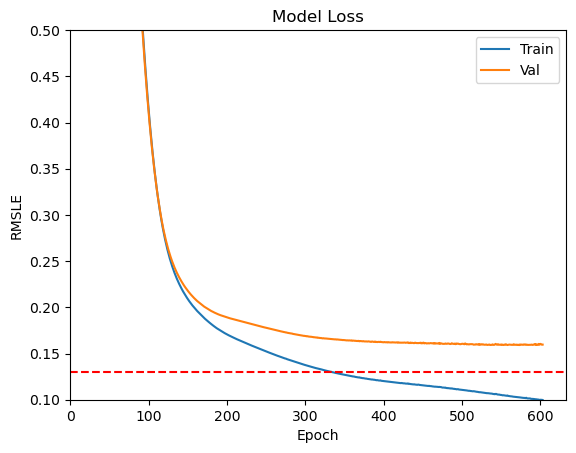

In [28]:
best_nn_model = es.model

plot_history(history, top=0.5, left=0)

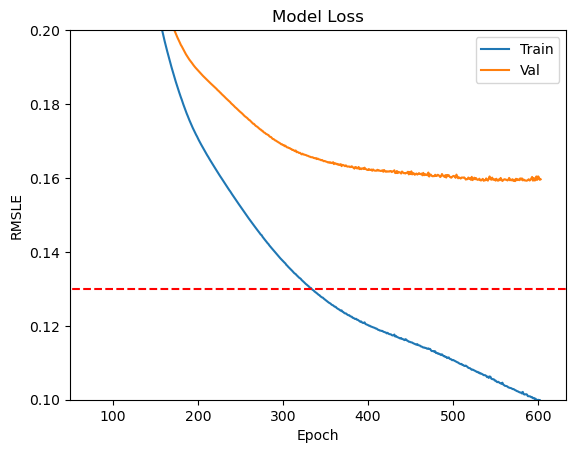

In [29]:
plot_history(history, top=.2, left=50)

# Export Result

In [34]:
data_test = pd.read_csv('data/test.csv', index_col='Id')
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [37]:
# Assign the best model
# best_model = best_nn_model
best_model = best_xgb_model

# Build the tuned pipeline
tuned_pipeline = make_pipeline(
    preproc_pipeline, 
    best_model
)

# Export the best prediction
result = 'xgb_0.12622245'
file_name_pickle = f'data/{result}.pickle'
file_name_csv = f'data/{result}.csv'

tuned_pipeline.fit(X, y)
y_pred_baseline=tuned_pipeline.predict(data_test)
df=pd.DataFrame(y_pred_baseline, index=data_test.index, columns=['SalePrice'])

df.to_csv(file_name_csv, index = True)

# Serialize the pipeline
import pickle
file_name_pickle = f'data/{result}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(tuned_pipeline, file)